# Unsupervised Learning in Generative DBN - Visualize Receptive Fields and Test Robustness  
### Boldrini - Sanguin


---



## Introduction to the project

The objective of this project is to implement simulations to explore computational models of visual concept learning.
The idea is to explore unsupervised learning in generative model with a Deep Belief Network and try to make sense of the rappresentation with our discoveries. We will try to visualize the receptive fields and the clustering representation.
Then, we will add a Linear-ReadOut to check the performance and compare it with a Feed Forward Neural Network. We will also probe both models by injecting noisy data to understand how robust they are to the sensory perturbation and have a comparison between them. Finally, we will use adversarial attack to see their responce.

In [1]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

We use some useful script from DBN and RBM. We are connecting from the remote serve for computing and downloading this data. 

In [2]:
%%capture
get_dbn_library()

In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as functional
import torchvision as tv
from tqdm.notebook import tqdm
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
from DBN import DBN

We import some useful function, using torchvision for Read Out Linear Classifier and Feed Forward Neural Network

## EMNIST dataset

For our project we are using the EMNIST dataset taken from [https://github.com/aurelienduarte/emnist]. So let's explore the dataset.  

First, we try to make sure that we have a cuda device that will speed up the train of the model. We set cuda like default device. 

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


Let's import the dataset. We choose the dataset of Emnist with only letters.

In [5]:
%%capture
emnist_train = tv.datasets.EMNIST('data/',
                                    split='letters', 
                                    train =True, 
                                    download=True,
                                    transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()])
                                      )

emnist_test = tv.datasets.EMNIST('data/',
                                    split='letters', 
                                    train =False, 
                                    download=True,
                                    transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()])
                                      )


We normalize the data by dividing by 255. It is the maximum value of pixel space. We divide by the maximum because we want value between 0 and 1.

In [6]:
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)

We shift the target labels by one so that the first value (N/A) will not be later analyze.

In [7]:
emnist_train.targets -= 1
emnist_test.targets -= 1

We send the data to the GPU.

In [8]:
emnist_train.data = emnist_train.data.to(device)
emnist_test.data = emnist_test.data.to(device)
emnist_train.targets = emnist_train.targets.to(device)
emnist_test.targets = emnist_test.targets.to(device)

It's now the moment to visualize our dataset:

In [9]:
# Info on the dataset
print("Number of images in Training dataset:    ",len(emnist_train))
print("Number of images in Testing dataset:     ",len(emnist_test))
print("Total Number of images in EMNIST dataset:", len(emnist_train) + len(emnist_test))


emnist_classes = emnist_train.classes
#emnist_classes.sort()
print("\nNumber of classes: ",len(emnist_classes))
print("List of all classes:")
print(emnist_classes)
print("List of targets labels:")
print(emnist_train.targets.unique().to("cpu").numpy())

Number of images in Training dataset:     124800
Number of images in Testing dataset:      20800
Total Number of images in EMNIST dataset: 145600

Number of classes:  27
List of all classes:
['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
List of targets labels:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


As we can see, we have 124800 images of letters in our training set and 20800 images in the test set. The images are 28x28 pixels, so 784 in total.
As we can see, there are 27 classes that are 26 letters and N/A.
Each letter corrisponds to a number between 0 and 26 in alfabetical order, so "a"= 0 and "z"= 25. 
Now we can print some images to have an idea with the data we are working with.

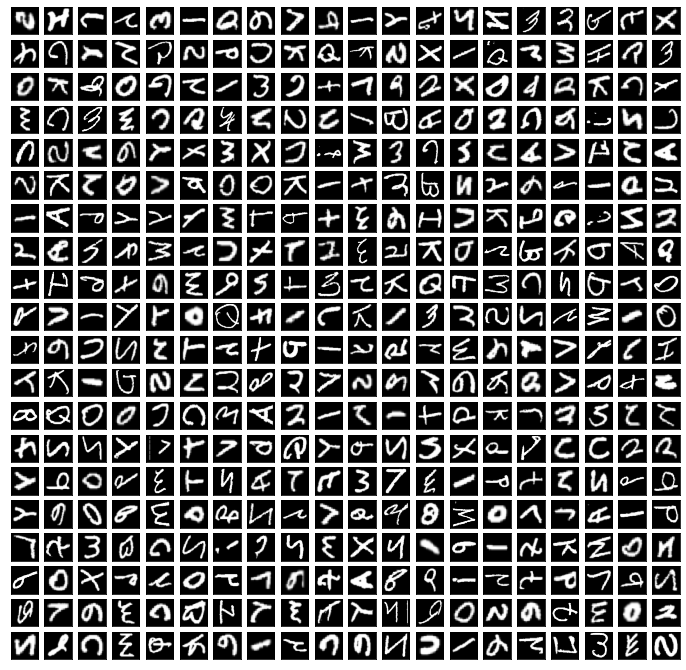

In [10]:
indices = torch.randint(0, len(emnist_train.data), (400,))
images = [emnist_train.data[i] for i in indices]

# Plot the images in a grid
fig = plt.figure(figsize=(12, 12))
for i in range(400):
    ax = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
    ax.imshow(images[i].to('cpu'), cmap='gray')

plt.show()

We can see that some images are also rotated and overturned. 

# DBN and Linear Read-Outs

## DBN

We have the data, the GPU avaible and we can train DBN.The visible layer are 28x28 pixel, with a fully connected model and the size is 784. We have 3 hidden layer with size 400,500,800. We use constrastic divergence equal to 1 and a constant learning rate equal to 0.1. 

In [11]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[400, 500, 800],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

We train our model for 50 epochs with batch size 150. We can see some diagnostics by the learning process. The average reconstraction error decrease during the train. This means that we have correctly upgraded our weights with gradient descent. We can also see the mean gradient and the standard deviation gradient to make sure that we are in a reasonable range.




In [12]:
num_epochs = 50
batch_size = 150

dbn_emnist.train_static(
    emnist_train.data,
    emnist_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.5793     |0.0472       |317.7173   |5.5821     |
|20    |1.5100     |0.0455       |300.6554   |4.9854     |
|30    |1.4963     |0.0436       |297.4024   |4.6036     |
|40    |1.4863     |0.0435       |294.8325   |4.5134     |
|50    |1.4826     |0.0441       |293.4963   |4.5494     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.9146     |0.0467       |211.0111   |3.0075     |
|20    |1.8431     |0.0429       |205.2369   |2.6132     |
|30    |1.8279     |0.0427       |204.0208   |3.1352     |
|40    |1.8222     |0.0461       |203.7870   |2.9199     |
|50    |1.8201     |0.0448       |203.6569   |2.7171     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.3454     |0.0350       |250.1072   |3.5180     |
|20    |1.2517     |0.0330       |235.9704   |3.339

After we have trained our unsupervised model we will try to decode its rappresentation using some read-out classifier. We use a linear classifier in order to understand how separable are the hidden rappresentations. If a linear classifier access a very high accuracy it means that the rappresentation are very disentangled, so the DBN discover some high level features and high level rappresentations.  
If the linear classifier has poor performance, it means that the generative model didn't discover a proper set of features.

## LINEAR READ OUT

We train a linear read-out classifier. 
We are using linear readouts as a way of producing an output from the hidden layers of our neural network. In this way we can compute the accuracy of our DBN+Linear-ReadOut.

In [13]:
class LinearModel(torch.nn.Module):
  def __init__(self, rbm_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, 26)

  def forward(self, x):
    return self.linear(x)

In [14]:
layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
linear_1 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[1].W.shape[1]
linear_2 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[2].W.shape[1]
linear_3 = LinearModel(layer_size).to(device)

In [15]:
def train(network, input, epochs=1500):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    targets = emnist_train.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch, epochs, loss))

We define the train function for the linear classifier. We use CrossEntropy as loss function. We backpropagate the gradient by backpropagation. 

Let's build readout layers for the three hidden representations of the DBN. We will only be using the last one, but you can play with them all in the next parts of the notebook.

In [16]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

We use this function to get the hidden state of the three layers.  

In [18]:
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

In [19]:
train(linear_1, hidden_repr_layer_1)
train(linear_2, hidden_repr_layer_2)
train(linear_3, hidden_repr_layer_3)

epoch :   0/1500, loss = 3.2944
epoch : 100/1500, loss = 2.1790
epoch : 200/1500, loss = 1.7198
epoch : 300/1500, loss = 1.4966
epoch : 400/1500, loss = 1.3667
epoch : 500/1500, loss = 1.2803
epoch : 600/1500, loss = 1.2174
epoch : 700/1500, loss = 1.1687
epoch : 800/1500, loss = 1.1293
epoch : 900/1500, loss = 1.0964
epoch : 1000/1500, loss = 1.0683
epoch : 1100/1500, loss = 1.0439
epoch : 1200/1500, loss = 1.0224
epoch : 1300/1500, loss = 1.0031
epoch : 1400/1500, loss = 0.9858
epoch :   0/1500, loss = 3.2948
epoch : 100/1500, loss = 2.1388
epoch : 200/1500, loss = 1.6939
epoch : 300/1500, loss = 1.4842
epoch : 400/1500, loss = 1.3628
epoch : 500/1500, loss = 1.2817
epoch : 600/1500, loss = 1.2223
epoch : 700/1500, loss = 1.1761
epoch : 800/1500, loss = 1.1386
epoch : 900/1500, loss = 1.1072
epoch : 1000/1500, loss = 1.0803
epoch : 1100/1500, loss = 1.0568
epoch : 1200/1500, loss = 1.0360
epoch : 1300/1500, loss = 1.0175
epoch : 1400/1500, loss = 1.0007
epoch :   0/1500, loss = 3.265

We can observe that the loss function still decrease and converge.

In [20]:
hidden_repr_layer_1_test = get_kth_layer_repr(emnist_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

Let's now predict the target labels for the data in the test set that we kept apart at the beginning, and use them to evaluate our trained linear readouts  to test how good is the classifier.


In [21]:
predictions_test1 = linear_1(hidden_repr_layer_1_test)
predictions_test2 = linear_2(hidden_repr_layer_2_test)
predictions_test3 = linear_3(hidden_repr_layer_3_test)

We have trained the linear ReadOuts on the different layers of DBN so that we can have a comparison between them, while calculating the accuracy.

In [22]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [23]:
compute_accuracy(predictions_test1, emnist_test.targets)


0.7309134602546692

We compute the accuracy at the first hidden layer and it is 73.09%.

In [24]:
compute_accuracy(predictions_test2, emnist_test.targets)

0.7243750095367432

We compute the accuracy at the second hidden layer and it is 72.43%.

In [25]:
compute_accuracy(predictions_test3, emnist_test.targets)

0.7512019276618958

We compute the accuracy at the third hidden layer and it is 75.12%.

We will use this accuracy later on and we will see the difference of accuracy with the Feed-Forward Neural Network. 

# Visualizing receptive fields

Now we will analyze the internal representations developed by the model by visualizing the recptive fields and later with hierarchical clustering. 

In [26]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights  

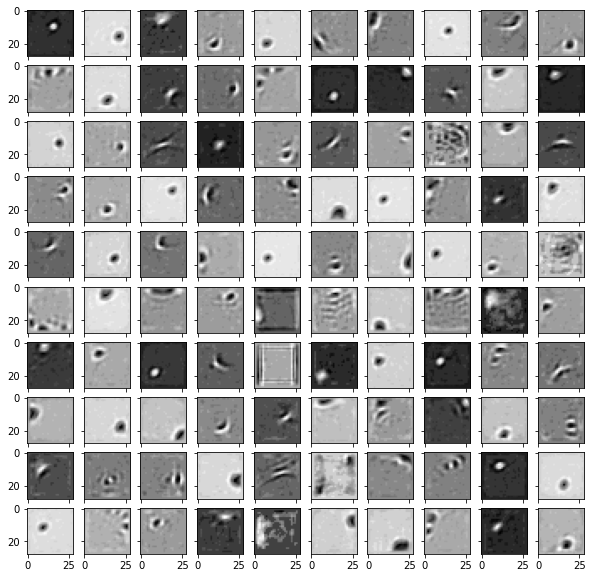

In [27]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)

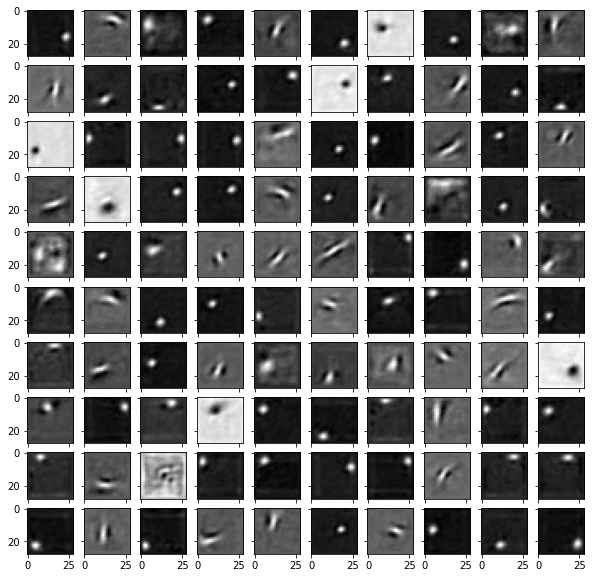

In [28]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T)

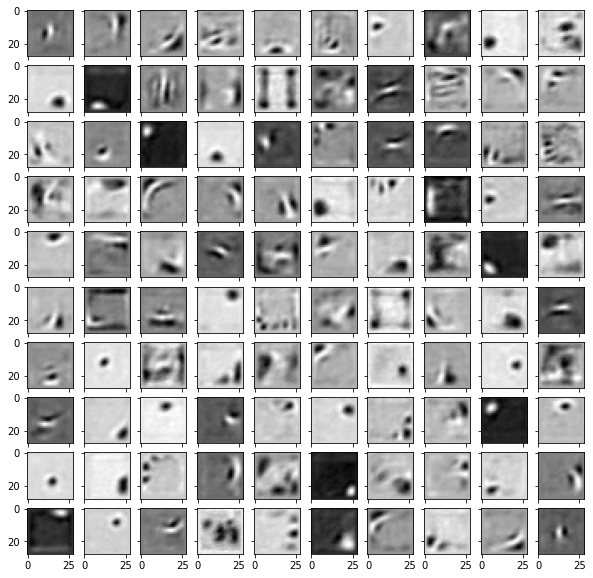

In [29]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)
learned_weights_layer_3 = get_weights(dbn_emnist, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)  # here we do the projection
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

plot_layer_receptive_fields(learned_weights_23_product.T)

A receptive field refers to the region of the input space that a particular neuron or group of neurons in a layer is sensitive to.
As we can see,the receptive fields of the third layer seems to be more complex than the ones in the first two layers.Infact, as we move deeper into the network, the receptive fields of the neurons become larger, as the filters in the lower layers capture local patterns while the filters in the higher layers capture more global patterns. This allows the network to learn hierarchical representations of the input data. 

# Clustering representation

We use clustering to group similar data points together based on some measure of similarity or distance. The goal of clustering is to identify natural groupings or clusters in the data, without any prior knowledge of the structure of the data.
In our case, we want to see which letters are similar to each other and so have more probability to be confused and misclassified. 

In [30]:
def get_mask(label):  # we use this function to filter by class
  labels = emnist_train.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(26)
  }

def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(26)])

In [31]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

In [32]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

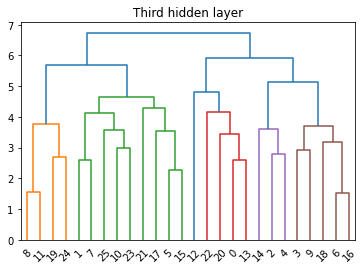

In [33]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

As we can see the dendogram, shows us the letters that are most similar. For example, 6 and 16 that are "G" and "Q" or 5 and 15 that are "F" and "P".

# Feedforward model

We now want to compare our DBN with an alternative model: FeedForward Neural Network.

We define a FeedForward Neural Network with three hidden layers to make it fair with our DBN. In each layer we are using linear classifier from the torch linear model, so that we can map the hidden rappresentation at the different level of the hierarchical model into the supervised classes. 

In [34]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(28*28, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 26)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

The forward method is telling torch how to prepagate information from the visible layer to the output layer. We use the activaction function ReLu. 

In [35]:
ffnn = Feedforward(400, 500, 800).to(device)

Let's train our FeedForward Neural Network.

In [36]:
train(ffnn, emnist_train.data.reshape((124800, 28*28)), epochs=1500)

epoch :   0/1500, loss = 3.2576
epoch : 100/1500, loss = 3.2253
epoch : 200/1500, loss = 3.0780
epoch : 300/1500, loss = 2.3805
epoch : 400/1500, loss = 1.7563
epoch : 500/1500, loss = 1.4920
epoch : 600/1500, loss = 1.3585
epoch : 700/1500, loss = 1.2543
epoch : 800/1500, loss = 1.1782
epoch : 900/1500, loss = 1.1069
epoch : 1000/1500, loss = 1.0469
epoch : 1100/1500, loss = 0.9908
epoch : 1200/1500, loss = 0.9381
epoch : 1300/1500, loss = 0.8883
epoch : 1400/1500, loss = 0.8416


We can see that the loss decrasing converge nearly to 0.
Now we compute the final accuracy.

In [37]:
predictions_ffnn = ffnn(emnist_test.data.reshape((20800, 784)))

In [38]:
compute_accuracy(predictions_ffnn, emnist_test.targets)

0.7638461589813232

Now we can see the difference of accuracy between the two models we trained. There is no much difference of accuracy:

-the DBN+LRO has 75,12% of accuracy 

-the FFNN has 76.38% of accuracy

It seems that FFNN performs better but we are considering in input images without noise. 
What will happen if we inject noise in the test images?

#Confusion matrix

Let's investigate the kind of errors made by the model using confusion matrices, also with the images disturbed by some noise.

We build the function to inject the noise in the test data and then make our prediction with the model we have already trained.  

In [39]:
def inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape, device = device)*noise_level
  return emnist_data + random_gaussian_tensor

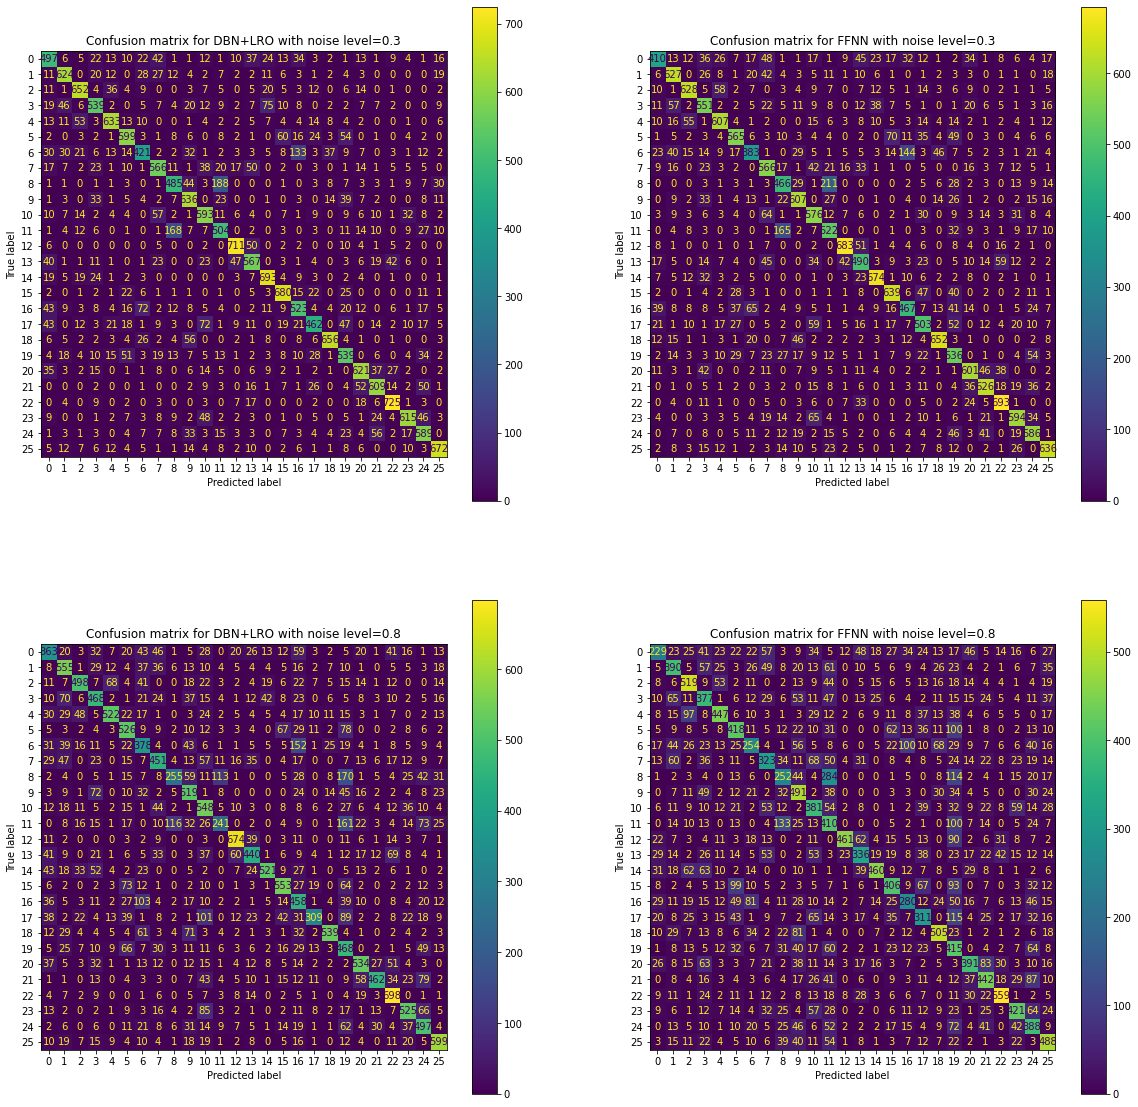

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json



noise_level1 = 0.3
noise_level2 = 0.8

#dbn+lro
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level1)  # first, let's create noisy test images
  
hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0, device)  # here we compute the DBN representations
hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)
  
predictions_first_hidden_noisy = linear_1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
predictions_second_hidden_noisy = linear_2(hidden_repr_layer_2_noisy)
predictions_third_hidden_noisy = linear_3(hidden_repr_layer_3_noisy)

predictions_indices = predictions_third_hidden_noisy.max(axis=1).indices

cm1 = confusion_matrix(emnist_test.targets.to('cpu').detach().numpy(), predictions_indices.to('cpu').detach().numpy())
 
  
  

# ffnn
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level1)  # first, let's create noisy test images
  
predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((20800, 784)))

predictions_indices = predictions_ffnn_noisy.max(axis=1).indices

cm2 = confusion_matrix(emnist_test.targets.to('cpu').detach().numpy(), predictions_indices.to('cpu').detach().numpy())


#dbn+lro 2
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level2)  # first, let's create noisy test images
  
hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0, device)  # here we compute the DBN representations
hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)
  
predictions_first_hidden_noisy = linear_1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
predictions_second_hidden_noisy = linear_2(hidden_repr_layer_2_noisy)
predictions_third_hidden_noisy = linear_3(hidden_repr_layer_3_noisy)

predictions_indices = predictions_third_hidden_noisy.max(axis=1).indices

cm3 = confusion_matrix(emnist_test.targets.to('cpu').detach().numpy(), predictions_indices.to('cpu').detach().numpy())
 
# ffnn 2
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level2)  # first, let's create noisy test images
  
predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((20800, 784)))

predictions_indices = predictions_ffnn_noisy.max(axis=1).indices

cm4 = confusion_matrix(emnist_test.targets.to('cpu').detach().numpy(), predictions_indices.to('cpu').detach().numpy())


  
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=list(range(26)))
disp1.plot(ax=axs[0,0])
axs[0,0].set_title('Confusion matrix for DBN+LRO with noise level=0.3')

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=list(range(26)))
disp2.plot(ax=axs[0,1])
axs[0,1].set_title('Confusion matrix for FFNN with noise level=0.3')

disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=list(range(26)))
disp3.plot(ax=axs[1,0])
axs[1,0].set_title('Confusion matrix for DBN+LRO with noise level=0.8')

disp4 = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=list(range(26)))
disp4.plot(ax=axs[1,1])
axs[1,1].set_title('Confusion matrix for FFNN with noise level=0.8')

plt.show()

We have printed confusion matrices for predictions with injected errors level 0.3 and 0.8. 
We can note that when we have small level of noise the confusion matrices of the two models are pretty similar, while when the noise increase the FFNN confusion matrix seems more "colourful" than the one of DBN+LRO. It means that it makes more mistakes when the images are noisy. 

#Robustness to noise and psychometric curves

Now we check another way to analyze the sensibility to errors in new predictions. 

We will now inject some noise in the input images and see how much the representations learned by the DBN and the feed-forward network are robust to perturbations in the sensory signal.

Similarly to what happens in psychophysical experiments, this will allow to create a psychometric curve describing the decrease in classification accuracy with respect to the noise level.

Let's visualize the images with an increasing level of noise.

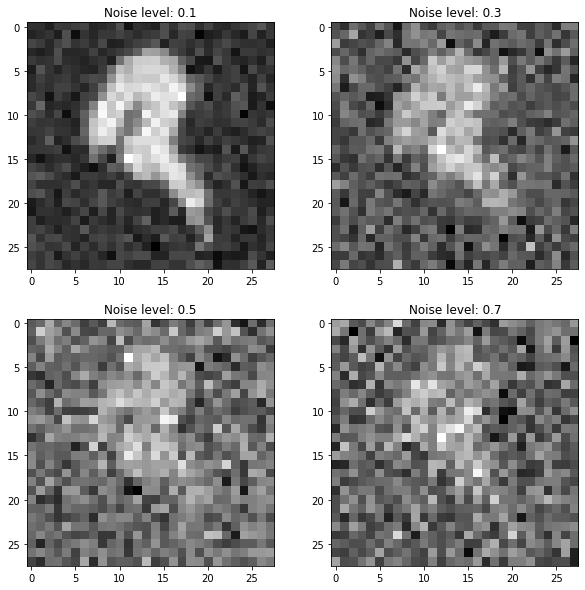

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

noise_level_list = [0.1, 0.3, 0.5, 0.7]
for idx, noise_level in enumerate(noise_level_list):
    row = idx // 2
    col = idx % 2
    emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)
    axs[row, col].imshow(emnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")
    axs[row, col].set_title(f"Noise level: {noise_level}")
    
plt.show()


The more noise we inject, the less the image is visible.

Let's compute now the accuracy value for different level of noise.

In [42]:
def get_accuracy_values_at_noise_level(noise_level):

  emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)  # first, let's create noisy test images
  
  hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)
  
  predictions_first_hidden_noisy = linear_1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear_2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear_3(hidden_repr_layer_3_noisy)
  
  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, emnist_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, emnist_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, emnist_test.targets)
  
  predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((20800, 784)))  # we repeat a similar process for the feed-forward model
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, emnist_test.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

We use the function inject_noise to put the noise into the emnist data.
We get the tree hidden layer using the noisy data as input and we get the prediction and the accuracy of this noisy rappresentation. 

In [43]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.694
Accuracy of H2 read-out: 0.712
Accuracy of H3 read-out: 0.742
Accuracy of FF network : 0.717


The difference in accuracy between the hidden layer of the DBN becomes even more pronunced and the third layer is the one that performs better with an accuracy of 0.742.
The feed-forward instead seems to be much less tollerant compare to the DBN with an accuracy  of 0.717.

The idea of phsycometric curves is to plot the accuracy against an increasing noise level. We create a new function plot_noise_robustness_curves that get an arrays of noise level and try to get the corrispondent accuracy.

In [44]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

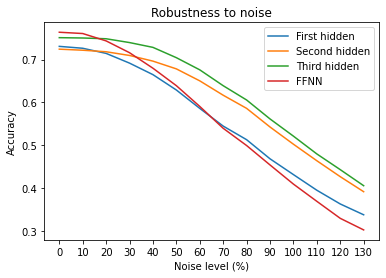

In [45]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

The phsicometric function is the function that shows you how the accuracy decreases as we increase the amount of noise. 
We see for the FeedForwrdNeuralNetwork, (the red line), is fearly bad. It decreases sticky similarly to the first hidden layer (blue line) in DBN.
In the second hidden layer (orange line)  the accuracy is much higher and in the third hidden layer (green line), it is the best one.
The rappresentation of the third hidden layer is very resistent to perturbation in the sensory input.


# Perturbing the models with adversarial attacks

### Fast gradient sign method

In an adversarial attack, the goal is to modify the input in such a way that the model can no longer correctly classify it. This means that the loss for that input should increase. When we train the model, we adjust its parameters to minimize the loss by moving in the opposite direction of the gradient. In an adversarial attack, we modify the input instead of the model parameters, and we move in the same direction as the gradient to increase the loss.

The adversarial sample will then look like:

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

In [46]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

This function takes as input an image. Epsilon is the amount of noise of the strenght of the attack. So it is an hyperparameter that tells us how strong we want to perturbate the image. If epsilon is very small, probabily you don't perceive the attack.

### Adversarial samples

We want to define a DBN+LRO, all together. The gradient must flow from the loss of the read out to the DBN to the input.

In [47]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_emnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_emnist = dbn_emnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_emnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_emnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [48]:
dbn_with_readout = DBNWithReadOut(dbn_emnist, [linear_1, linear_2, linear_3], readout_level=2)

Let's see what an adversiarial sample looks like. Let't take one sample from the test set:

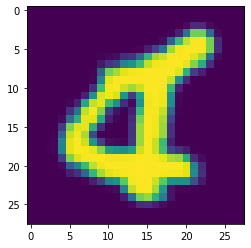

In [65]:
test_sample_idx = 5
test_image = emnist_test.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))

Let's classify this "clean" image using the FFNN first. Then we will attack it and classify it again.


In [74]:
attacked_model = ffnn

In [75]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 0.


Let's create and visualize the corresponding adversarial sample. 
The function `loss.backward()` computes the gradient for every parameter that was activated using the call `requires_grad=True`.

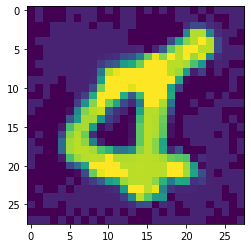

In [76]:
epsilon = 0.1  # define strenght of the attack
test_image_label = emnist_test.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [77]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 13.


We can see that the model misclassify this sample. It has recognize "N" instead of "A". 

Now we try with the DBN+LRO.

In [78]:
attacked_model = dbn_with_readout

In [79]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 0.


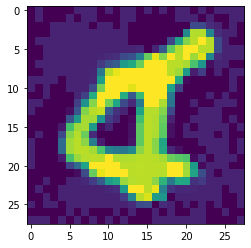

In [80]:
epsilon = 0.1  # define strenght of the attack
test_image_label = emnist_test.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [81]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 0.


In this case the model recognize correctly the letter "A".

### Resisting to adversarial attacks

Let's now compare the ability to resist to adversarial attacks of our two models: the feedforward network and the DBN.


In [82]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack
        
        output = model.forward(data)

        init_pred = torch.argmax(output)
        
        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_emnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

To avoid a cuda error we import the emnist dataset again and remove the N/A class.

In [83]:

emnist_test_1 = tv.datasets.EMNIST('data/',
                                    split='letters', 
                                    train =False, 
                                    download=False,
                                    transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()])
                                      )


In [84]:
emnist_test_1.targets -= 1

In [85]:
test_loader = torch.utils.data.DataLoader(
    emnist_test_1,
    batch_size=100, shuffle=True)

Let's see how good the FFNN does:

In [86]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 22.97%



Let's see how good the DBN+LRO does:

In [87]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1, 
                                      num_steps=0)

  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 53.99%



And finally let's test whether using one step of top-down reconstruction from the generative model allows to improve resilience to attacks:

  0%|          | 0/208 [00:00<?, ?it/s]


Here's the original sample:



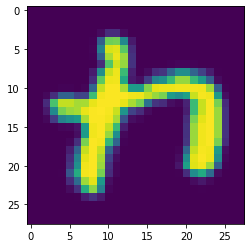


Here's a perturbed sample:



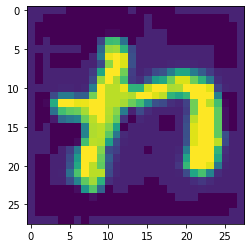


Here's what a 1-steps reconstructed sample looks like:



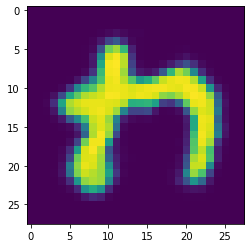


Epsilon: 0.1
Test Accuracy: 59.11%



In [88]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

### Effect of the noise parameter $\epsilon$

Let's compare the robustness of each model to adversarial attacks of different "strengths":

In [89]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [90]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

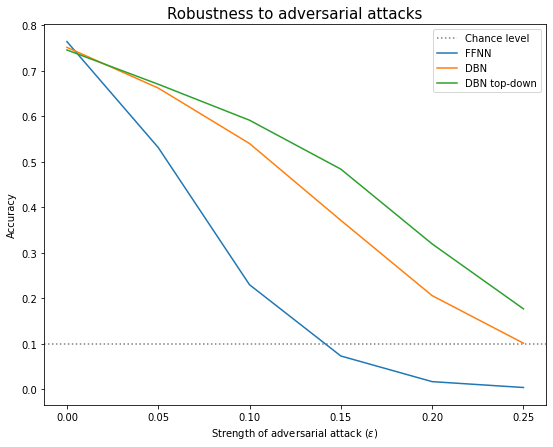

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

From the plot we can say that the FFNN is the one that performs the worst and the DBN+LRO with one step of top-down reconstruction is the better in terms of strength of adversarial attack.

# Conclusions

To summarize our work we trained a Deep Belief Network and Linear-ReadOut to study and analize the features of the images of the Emnist dataset. 
To do so we have seen by cluster representation and by visualizing receptive fields how the model works and how it classify similar data. 

Also, we compared this generative model with a Feed Forward Neural Network.
We noticed at first that the accuracies were very similar but later we found major difference when we looked at confusion matrices and psychometric curves.
In fact, when we tested the prediction of the two model in presence of noise we have seen that the DBN+LRO performs better than the FFNN.

To have a final confirmation of this performance's diffrence we also tested the response to adversarial attacks in the two model taken into account. Here we found out that the DBN+LRO have a better image reconstruction. In particular, we have seen that using one step of top-down reconstruction in the generative model allows to improve resilience to attacks. 
We found, with epsilon=0.1, an accuracy of 59.11% for the DBN and a poor 22.97% for the FFNN.

In conclusion, we have small doubts for which model it's more suitable to use when investigating a dataset. 
